# Predictive Model in a Hurry
There's no better feeling than sitting back after hours of wrangling data in SQL and admiring the pristine dataset you've just created. After creating one such dataset, my supervisor was curious if it could be used to predict a certain target variable. He asked me to find out and get back to him at our next meeting - in two hours. After a little discussion about the limitations of what I could do in that time, we landed on the following goal: to find out which, if any, of the variables were predictive of the target, and to get a sense of the strength of this predictive power. We also agreed to assess correlation through scatter plots and binned scatterplots between features and our target variable, as well as viewing their Pearson's coefficient. We also agreed to create a cookie-cutter model and agreed on a baseline root mean squared error and $R^2$, based on previous experience. Lastly, I would use tree based feature importance to find the most relevant features from the dataset.

By the time I sat down at my desk it was set to be a quick hour and a half project, and one that wasn't very consequential - we just wanted to know if the predictive power was there, I didn't need to actually make a working model. But the quick timeframe did make me focus on what I thought were the most important steps in the machine learning process, and along the way I created what is essentially a cookie-cutter formula to predictive modeling. The most important thing you'll notice is that I spent almost all of my time on feature engineering. No matter what the timeline, this is always the most essential part of the process, and it needs its due time. Follow along to see what I did when I was put under a time crunch!

Before we dive into modeling, it's important to note that most of the work for this small project was already done - I had a cleaned dataset with null values handled and outliers validated. With that huge caveat out of the way, let's dive a little deeper into the process that I took.

I began by graphing my features versus the target variable to get a sense of their relationships. I created grouped box and kernelt density plots for binary variables, and scatterplots and hexagonal bins for numeric variables. The scatterplots inspired me to create grouped scatterplots, displaying 95% confidence intervals for qualitatively distinct bins. Unfortunately I won't be displaying these, because companies don't usually like when you share all their data. Since I have prewritten functions to perform these tasks, it only took me a couple of minutes to make the plots, then spent about ten minutes looking over the graphs. I was fairly familiar with the dataset and already had a pretty good idea of what to look for. In summary, this initial step served to confirm my initial guesses about useful features to engineer, as well as inspired some ideas for new ones.

Below I load our cleaned dataset and verify that we do in fact have no null values. The plots are unfortunately omitted.


### Data Validation and Visualization (sadly, mostly omitted)

In [11]:
import time
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Visualization settings.
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = None


In [12]:
train_path = '/Users/justinsima/dir/projects/portfolio/quick_model/train.csv'
features_path = '/Users/justinsima/dir/projects/portfolio/quick_model/engineered_features.csv'
df = pd.read_csv(train_path)

# Ensure there are no null or infinite values before fitting.

num_na = sum(df.isna().sum() > 0)
print(f'Number of columns with null values: {num_na}')

bool_finite = np.all(np.isfinite(df.select_dtypes('number')))
print(f'Are all values finite? {bool_finite}')


Number of columns with null values: 0
Are all values finite? True


Technically I lied, since one column did in fact have plenty of null values. But I transformed this column into an indicator column, so you can't tell.

### Feature Engineering

The next step was to create some new basic features based on the information I had gained from my initial EDA. First I created two new features that were algebraic combinations of existing feautures, and then created a column binning one of our numerical features. I also changed a string column slightly, which would come in handy later.


In [13]:
# Change string column to upper case.
df['x_4'] = df['x_4'].str.upper()

# Create domain knowledge inspired features.
df['x_27'] = df['x_6'] * df['x_5']

maximum_sqft = np.max(df['x_27'])
df['x_28'] = pd.cut(
    x=df['x_27'],
    bins=[0, 37.5, 62.5, 87.5, 112.5, 162.5, 175, 225, 275, 325, 375, 425, 475, maximum_sqft],
    labels=[0./12, 1./12, 2./12, 3./12, 4./12, 5./12, 6./12, 7./12, 8./12, 9./12, 10./12, 11./12, 12./12]
)

df['x_30'] = df['x_27'] ** 2
df['x_31'] = df['x_27'] ** 3


Unfortunately I can't share all the cool details of the next steps, because it was how i spent the majority of my time (and it was the most fun part!). Suffice it to say that some clever use of Pandas, domain knowledge, and a supplementary dataset helped create four new features that were likely to be useful for prediction. By the way, the string column that was transformed above was transformed so that it could be joined to this table more easily.

Below I load those mystery features and concatenate them to our dataset.

In [14]:
# Load features.
features_path = '/Users/justinsima/dir/projects/portfolio/quick_model/engineered_features.csv'
engineered_features = pd.read_csv(features_path)
engineered_features.set_index('index', inplace=True)

# Combine with our original dataset.
df = df.join(engineered_features, how='left')


Next I decided to handle two categorical variables slightly differently. I transformed one column by changing it to an indicator variable (is present, or is null), and transformed one multi-class variable into a binary one. Note that I resaved the dataframe after performing one of these transformations, so this is now commented out.

In [15]:
# Add indicator variable for parking units.
df['x_29'] = (df['x_4'] == 'fake_flag').map({False:0, True:1})

# # Convert discount to indicator.
# df['x_19'] = df['x_19'].isna().map({True:0, False:1})


We're now ready to complete our second task! With our features prepared, we can find the Pearson's Correlation between them and our target variable, as desired.

In [16]:
corrs = df.corr().target
corrs[abs(corrs) > 0.05]


x_5       0.612387
x_6       0.565630
x_10      0.247770
x_11      0.110421
x_15     -0.056721
x_17     -0.105585
target    1.000000
x_21      0.136449
x_23     -0.134594
x_27      0.568539
x_30      0.081825
feat_1    0.106854
feat_2    0.131990
feat_3    0.203786
feat_4   -0.102078
Name: target, dtype: float64

### Feature Scaling

With my features created and correlations calcutated, it was time for scaling. I was tempted to just use sklearn's StandardScaler and worry about specific scaling by feature in the future, but I was ahead of schedule and feeling ambitious, so I decided to try a few transformations for each numeric variable and choose the one that resulted in the qualitatively based distribution. Since time was of the essence, I didn't spend much time looking at each variable, so there is a very high change that I made some less than ideal decisions.

The code and results are below.


Variable of Interest: x_5



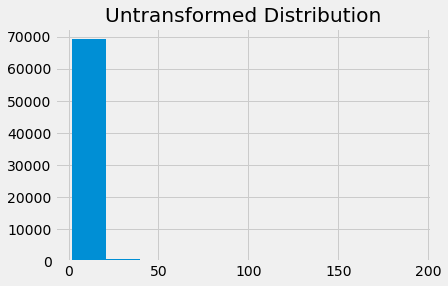

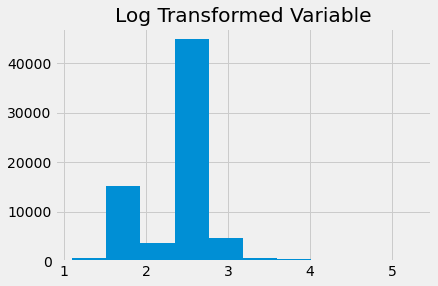

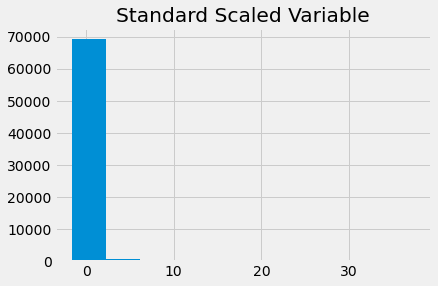

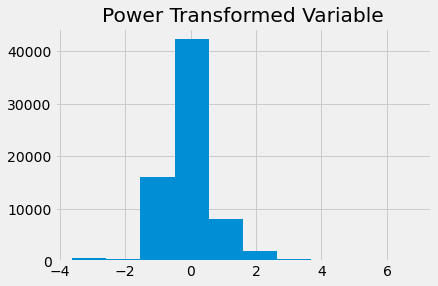

Variable of Interest: x_6



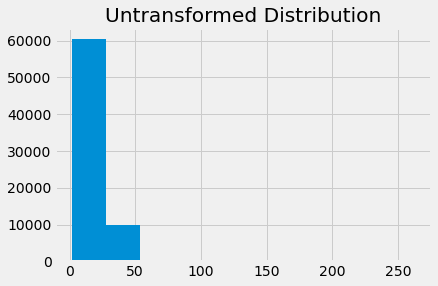

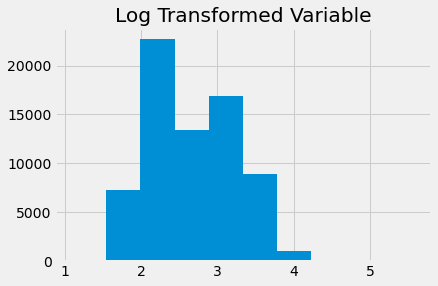

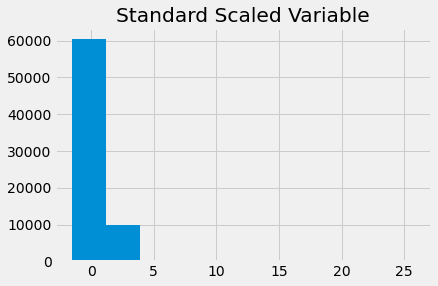

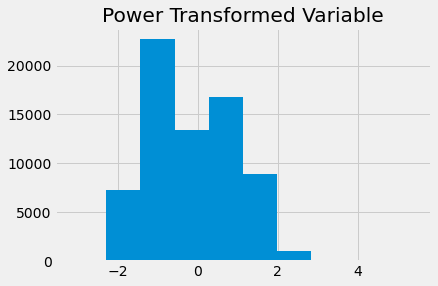

Variable of Interest: x_20



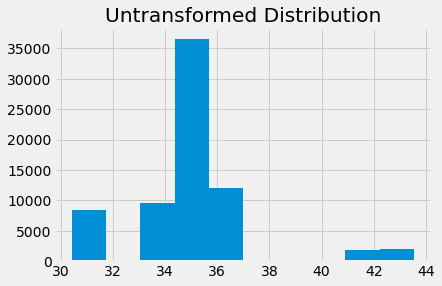

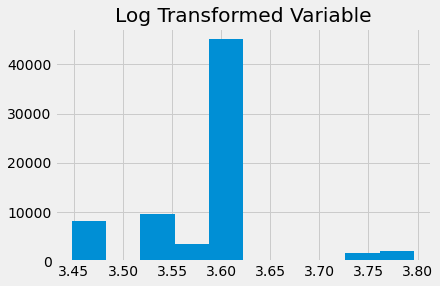

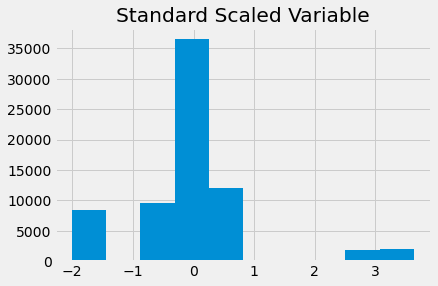

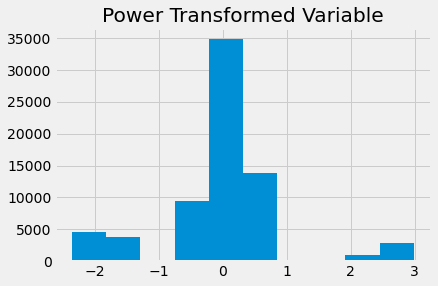

Variable of Interest: x_21



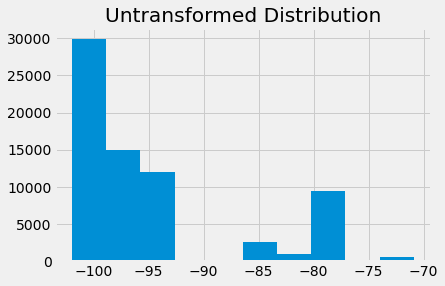

Problem with column:  x_21
Variable of Interest: x_22



/opt/homebrew/Caskroom/miniforge/base/envs/my_env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/homebrew/Caskroom/miniforge/base/envs/my_env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


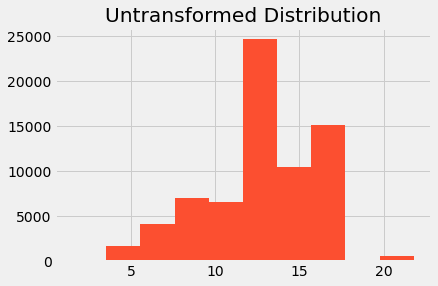

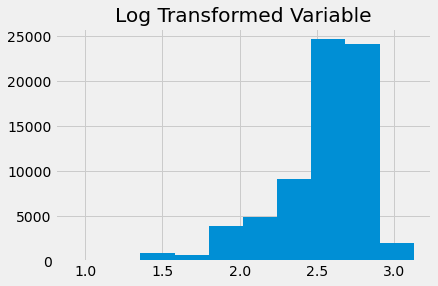

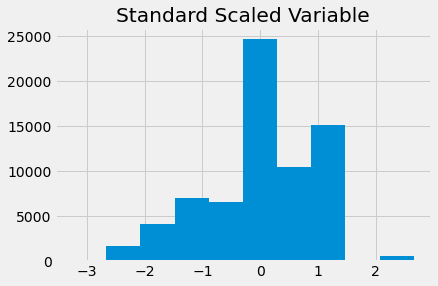

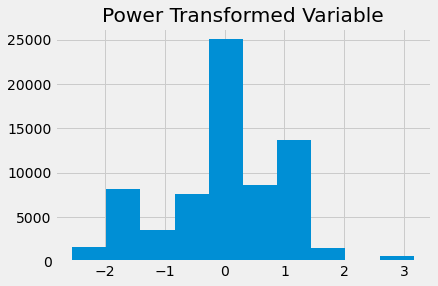

Variable of Interest: x_23



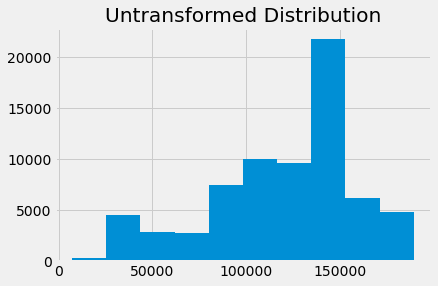

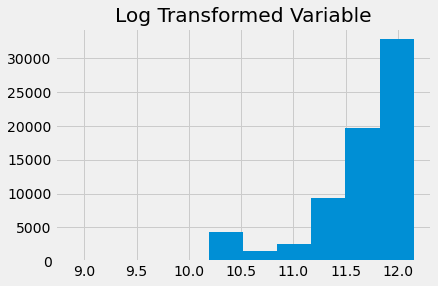

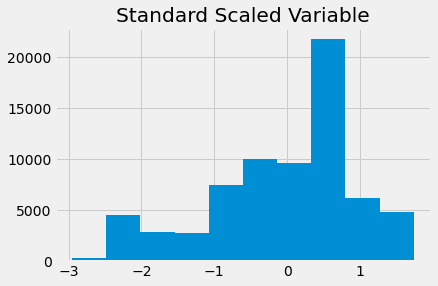

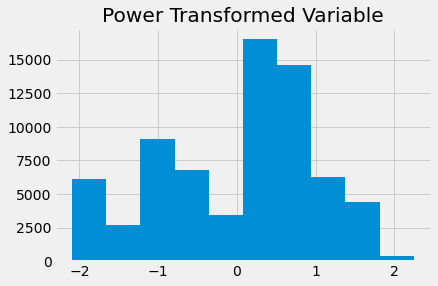

Variable of Interest: x_24



/opt/homebrew/Caskroom/miniforge/base/envs/my_env/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3251: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


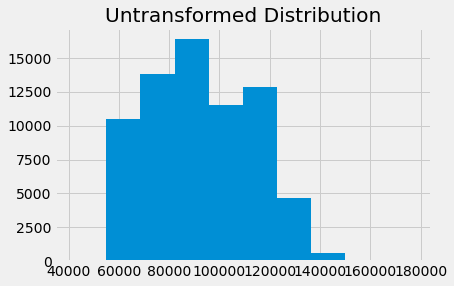

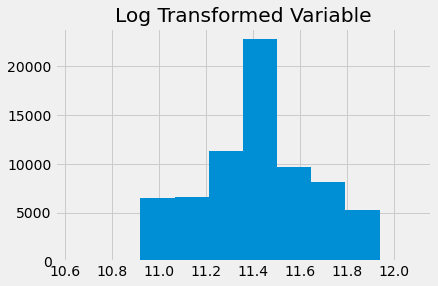

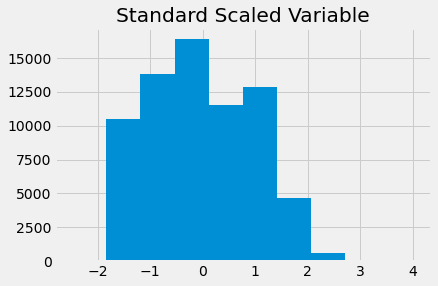

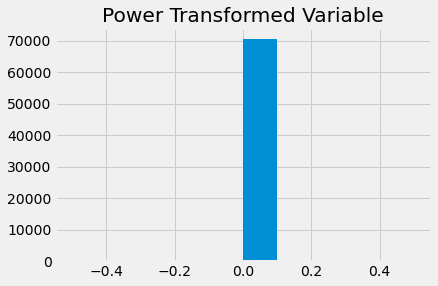

Variable of Interest: x_25



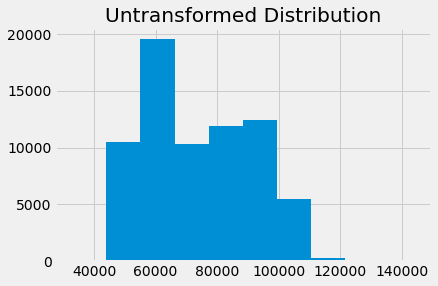

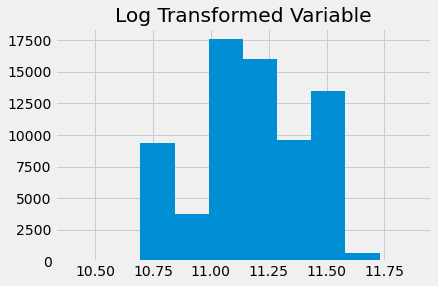

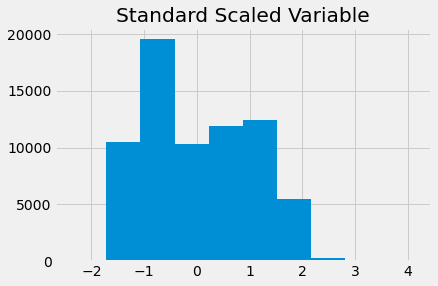

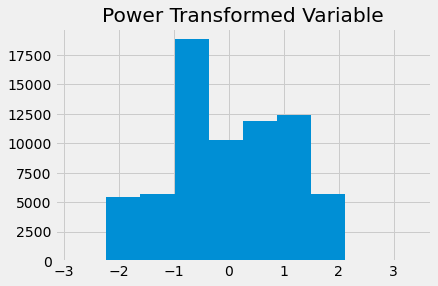

Variable of Interest: x_27



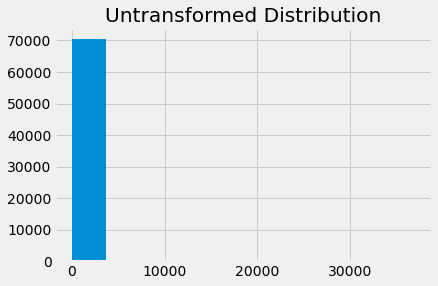

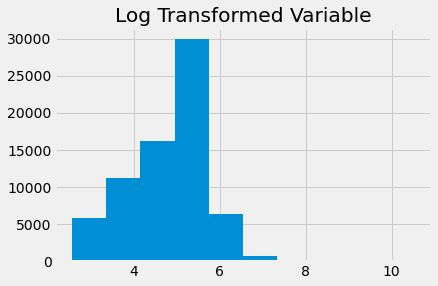

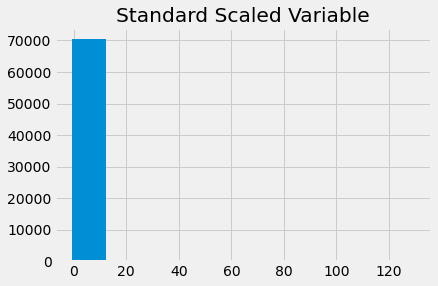

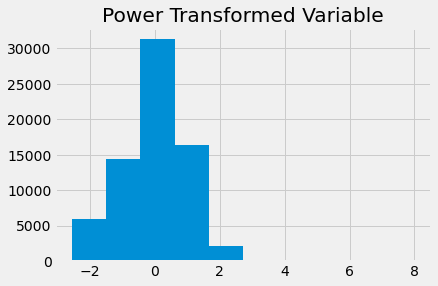

Variable of Interest: feat_1



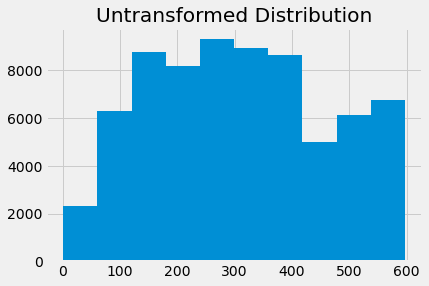

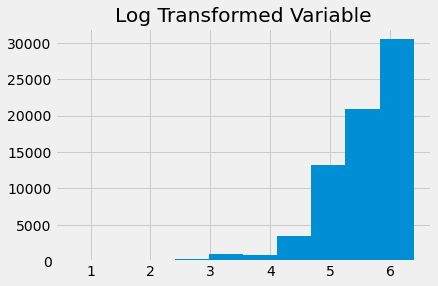

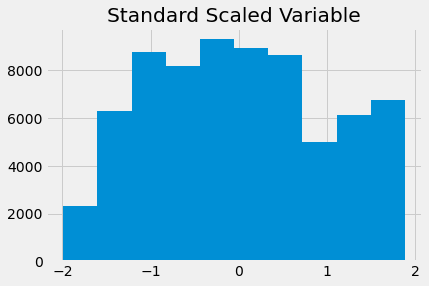

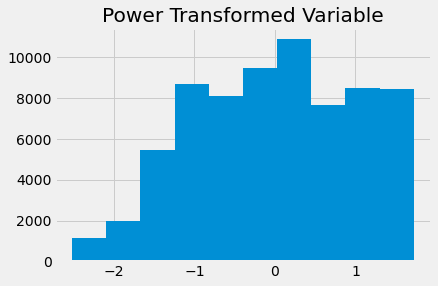

Variable of Interest: feat_2



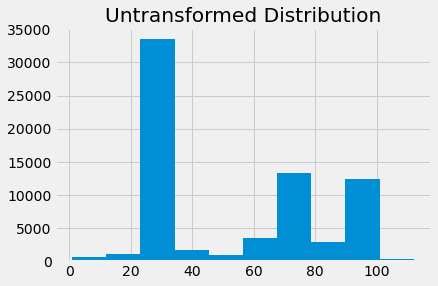

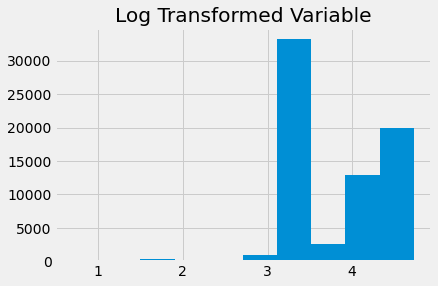

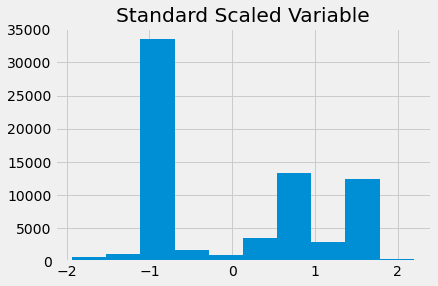

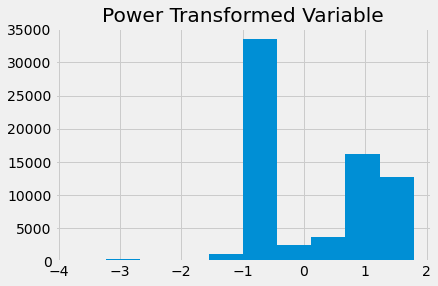

Variable of Interest: feat_3



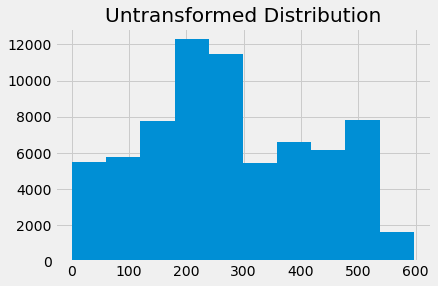

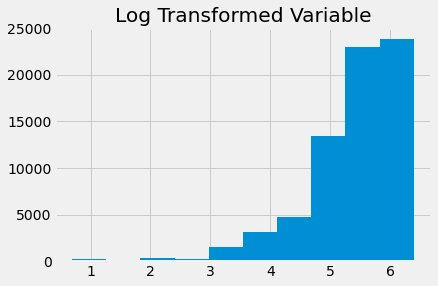

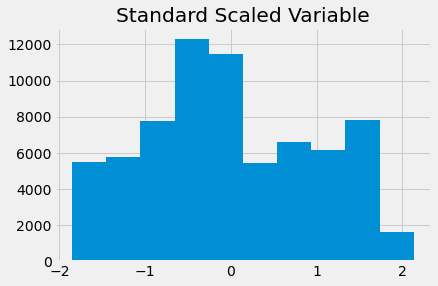

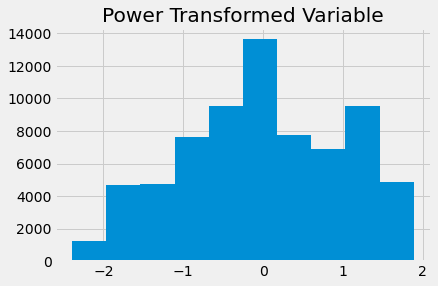

Variable of Interest: feat_4



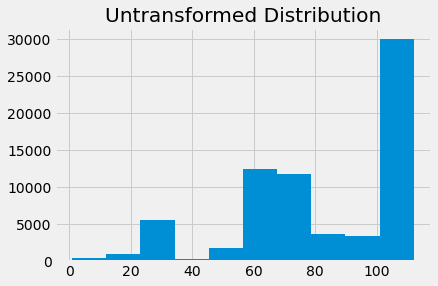

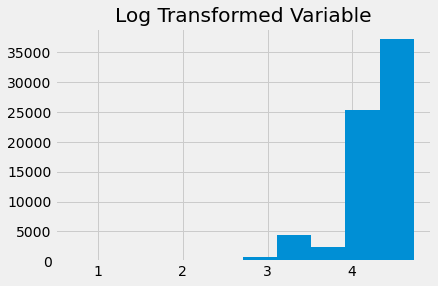

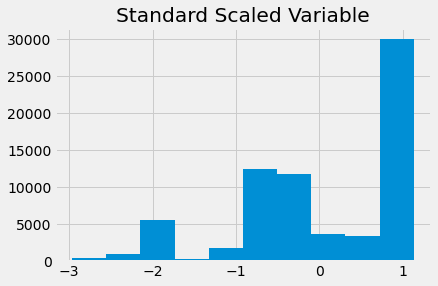

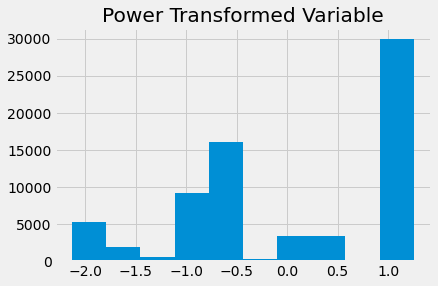

Variable of Interest: feat_5



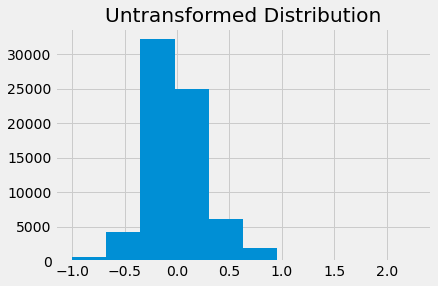

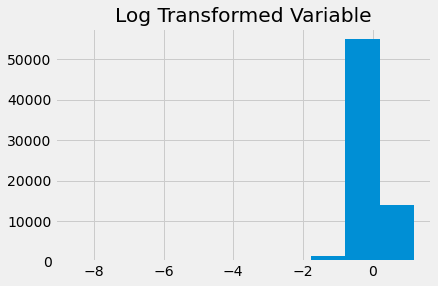

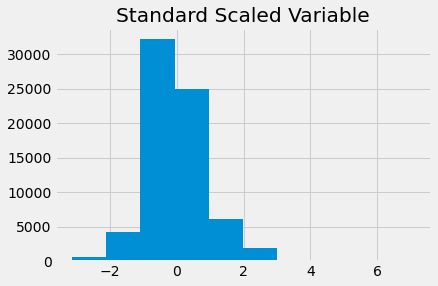

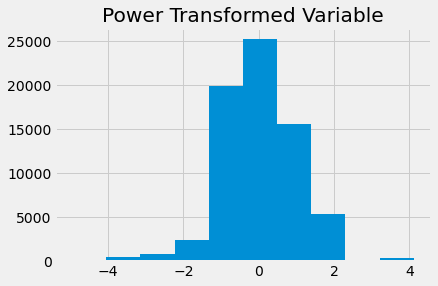

In [17]:
cols_numeric = [
    'x_5',
    'x_6',
    'x_20',
    'x_21',
    'x_22',
    'x_23',
    'x_24',
    'x_25',
    'x_27',
    'feat_1',
    'feat_2',
    'feat_3',
    'feat_4',
    'feat_5'
]

for col in cols_numeric:
    try:
        x = df[[col]]
        x_log = FunctionTransformer(np.log1p).fit_transform(x)
        x_std = StandardScaler().fit_transform(x)
        x_power = PowerTransformer().fit_transform(x)

        print(f'Variable of Interest: {col}\n')

        plt.hist(x)
        plt.title('Untransformed Distribution')
        plt.show()

        plt.hist(x_log)
        plt.title('Log Transformed Variable')
        plt.show()

        plt.hist(x_std)
        plt.title('Standard Scaled Variable')
        plt.show()

        plt.hist(x_power)
        plt.title('Power Transformed Variable')
        plt.show()
    except:
        print('Problem with column: ', col)
    

We're now ready to create our transformer and transform our dataset for modeling.

In [18]:
# Group columns by desired scaling process.
COLS_BC = [
    'x_6',
    'x_5',
    'x_22',
    'x_23',
    'x_27',
    'x_30',
    'x_31'
    
]
COLS_STDSCALE = [
    'x_20',
    'x_21',
    'x_24',
    'x_25',
    'feat_1',
    'feat_2',
    'feat_3',
    'feat_4',
    'feat_5'
]

# Create column transformer.
scaler = make_column_transformer(

    (make_pipeline(
        PowerTransformer(), StandardScaler()),
    COLS_BC),

    (StandardScaler(),
    COLS_STDSCALE),

    remainder='passthrough'
)
scaler = make_pipeline(scaler)


In [19]:
# Drop columns that will not be used for prediction.
cols_drop = [
    'x_1',
    'x_2',
    'x_3',
    'x_4',
    'x_26'
]
df = df.drop(columns=cols_drop, errors='ignore')


In [20]:
# Separate into training and validation sets.
df_train = df.sample(frac=0.8, random_state=49)
df_val = df.drop(df_train.index).sample(frac=1.0) # Resample to shuffle dataset.

# Separate and scale features and labels.
X_train = df_train.drop(columns='target').copy()
y_train = df_train['target'].copy()

X_val = df_val.drop(columns='target').copy()
y_val = df_val['target'].copy()

scaler.fit(X_train, y_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))
X_train_scaled.columns = X_train.columns

X_val_scaled = pd.DataFrame(scaler.transform(X_val))
X_val_scaled.columns = X_val.columns

y_train = np.log1p(y_train)
y_val = np.log1p(y_val)


/opt/homebrew/Caskroom/miniforge/base/envs/my_env/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3251: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Next let's talk about model selection. It's important to remember that I don't want to just throw all of my features into a model - I want to see which features are important as well. 
This was the main reason I decided to use a random forest model, as we can use either impurity or permutation based methods to determine feature importance. I chose a random forest over something like XGBoost beccause I wasn't confident in all of my feature scaling and was therefore tenative of a gradient based approach.
A random forest was also preferred to a linear model, as it allows us to model non-linear relationships - remember, I'm not trying to find the most appropriate model right now, just a model that is sufficient.
That being said, I did also train a simple linear regression model, because the dataset is fairly small and I couldn't help myself. Time was a factor, so I didn't have time to actual perform parameter tuning.

I decided on the following process:
1. Begin with all features and train an untuned random forest model. Save scores on validation set.
2. Using impurity based feature selection (since this is computed for free), remove the least important feature.
3. Repeat until the mininimum feature importance reaches a threshold (in this case 0.01).
4. Fit a random forest and linear regressin model on the remaining features.

The code and results are included below.


Feature dropped: feat_5
Feature dropped: x_10
Feature dropped: x_11
Feature dropped: x_29
Feature dropped: x_23
Feature dropped: x_24
Feature dropped: x_28
Feature dropped: x_31
Feature dropped: x_22
Feature dropped: feat_3
Feature dropped: feat_2
Feature dropped: x_27
Feature dropped: x_8
Feature dropped: x_6
Feature dropped: x_7
Feature dropped: x_17
Feature dropped: x_5
Feature dropped: x_19
Feature dropped: x_20
Feature dropped: x_15
Done. Elapsed time 190.52435088157654
Remaining Features:

x_9
x_12
x_13
x_14
x_16
x_18
x_21
x_25
x_30
feat_1
feat_4
Trial R_2 Scores:

Trial 0 R_2 Score: 0.9911712166900062
Trial 1 R_2 Score: 0.9912796693612761
Trial 2 R_2 Score: 0.9911955117505217
Trial 3 R_2 Score: 0.9913330619222745
Trial 4 R_2 Score: 0.9912528957374556
Trial 5 R_2 Score: 0.9911782947367369
Trial 6 R_2 Score: 0.9910261979799702
Trial 7 R_2 Score: 0.9910839118567767
Trial 8 R_2 Score: 0.9910423845442922
Trial 9 R_2 Score: 0.9908673294878754
Trial 10 R_2 Score: 0.9908590128879168
Tri

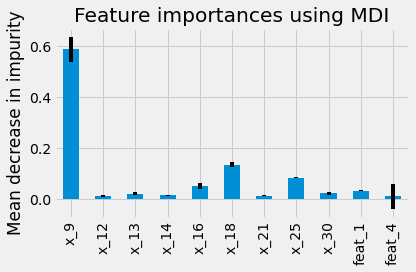

In [21]:
#Experiment to choose relevant features.

start_time = time.time()

# Initialize variables and containers.
trial_scores = []
features_dropped = []
smallest_importance = 0
threshold = 0.01

# Fit model and drop least important feature, until we reach a feature importance threshold.
while smallest_importance < threshold:
    # Create, fit, and score model.
    rf = RandomForestRegressor()
    rf.fit(X_train_scaled, y_train)
    r2 = rf.score(X_val_scaled, y_val)
    trial_scores.append(r2)

    # Find the least important feature and its corresponding score.
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

    feature_names = X_train_scaled.columns
    forest_importances = pd.Series(importances, index=feature_names)

    ordered_forest_importances = forest_importances.sort_values(ascending=False)
    feature_drop = ordered_forest_importances.tail(1).index[0]
    smallest_importance = ordered_forest_importances[-1]
    
    # Drop feature if its score falls below threshold.
    if smallest_importance < threshold:
        X_train_scaled = X_train_scaled.drop(columns=[feature_drop])
        X_val_scaled = X_val_scaled.drop(columns=[feature_drop])

        print(f'Feature dropped: {feature_drop}')
        features_dropped.append(feature_drop)

elapsed_time = time.time() - start_time

print(f'Done. Elapsed time {elapsed_time}')

print(f'Remaining Features:\n')
for col in X_train_scaled.columns:
    print(col)
    
print('Trial R_2 Scores:\n')
for trial_num, score in enumerate(trial_scores):
    print(f'Trial {trial_num} R_2 Score: {score}')

feature_names = X_train_scaled.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


With our relevant features located we can now create our final models. I began setting up a gridsearch to tune my hyper-parameters slightly, but realized that there wasn't enough time and abandoned it. It's much less important than our feature engineering, so I'm fine with this time trade-off.

The code and results are included below.


In [22]:
# Create parameter grid and 5 folds for grid search.
# param_grid = {
#     'n_estimators':[100]
# }
# kfolds = KFold(
#     n_splits=5,
#     shuffle=True,
#     random_state=49
# )

# # Initialize model.
# rf_pipe = RandomForestRegressor()

# # Create gridsearch.
# rf_grid = GridSearchCV(
#     estimator=rf_pipe,
#     param_grid=param_grid,
#     scoring='neg_root_mean_squared_error',
#     cv=kfolds
# )

# # Perform gridsearch and save the best parameters.
# rf_grid.fit(X_train_scaled, y_train)
# best_params = rf_grid.best_params_
# best_params['n_estimators'] = 10_000

# # Refit model with best parameters.
# rf = RandomForestRegressor(**best_params)
# rf.fit(X_train_scaled, y_train)

# Fit random forest model and make predictions.
rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train_scaled, y_train)

rf_preds = rf.predict(X_val_scaled)

# Fit linear regression model and make predictions.
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

preds = linear_reg.predict(X_val_scaled)

# Calculate and display model performances with pre-chosen metrics.
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_preds))
rf_mae = mean_absolute_error(y_val, rf_preds)
rf_r2 = r2_score(y_val, rf_preds)

rmse = np.sqrt(mean_squared_error(y_val, preds))
mae = mean_absolute_error(y_val, preds)
r2 = r2_score(y_val, preds)

print(f'Random Forest RMSE: {rf_rmse}')
print(f'Random Forest MAE: {rf_mae}')
print(f'Random Forest R-Squared: {rf_r2}')

print(f'Linear Regression RMSE: {rmse}')
print(f'Linear Regression MAE: {mae}')
print(f'Linear Regression R-Squared: {r2}')


Random Forest RMSE: 0.06944044623568199
Random Forest MAE: 0.02543967315656004
Random Forest R-Squared: 0.9872765227116268
Linear Regression RMSE: 0.23333887031784453
Linear Regression MAE: 0.15779415021897197
Linear Regression R-Squared: 0.8563336709745744


And that's it! In about an hour and a half, I was able to get a pretty good idea that there certainly was predictive power in our feature set, and was able to identify which features were the most relevant for prediction. Moreover, I had linear correlations and impurity based feature importance scores with which to objectively compare the relevance of each feature. This prediction task was far from over, but it was a good start!